## **Importing libraries and datasets**

In [1]:
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
import xgboost as xgb

from sklearn.metrics import precision_score, recall_score, f1_score, auc, roc_auc_score, accuracy_score, classification_report, confusion_matrix, roc_curve
from xgboost import plot_importance
import sklearn.model_selection as model_selection
import sklearn.preprocessing as preprocessing
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import ParameterGrid
from xgboost import XGBClassifier

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
df_response = pd.read_csv('/content/drive/MyDrive/CRM/Campaign Response Model/Retail_Data_Response.csv')
df_transactions = pd.read_csv('/content/drive/MyDrive/CRM/Campaign Response Model/Retail_Data_Transactions.csv', parse_dates=['trans_date'])
print("df_response",df_response.shape)
print("df_transactions",df_transactions.shape)
print(df_response.head())
print(df_transactions.head())

df_response (6884, 2)
df_transactions (125000, 3)
  customer_id  response
0      CS1112         0
1      CS1113         0
2      CS1114         1
3      CS1115         1
4      CS1116         1
  customer_id trans_date  tran_amount
0      CS5295 2013-02-11           35
1      CS4768 2015-03-15           39
2      CS2122 2013-02-26           52
3      CS1217 2011-11-16           99
4      CS1850 2013-11-20           78


## **Data Preparation**

In [6]:
## since the last date of the data is 16 March 2015, the campaign date is assumed to be 17 March 2015
## RFM model will be used to predict campaign response. Recency is calculated

print(df_transactions['trans_date'].min())
print(df_transactions['trans_date'].max())

campaign_date = df_transactions['trans_date'].max() + dt.timedelta(days=1)
print(campaign_date)
df_transactions['recent']= campaign_date - df_transactions['trans_date']
df_transactions['recent'].astype('timedelta64[D]')
df_transactions['recent']=df_transactions['recent'] / np.timedelta64(1, 'D')
df_transactions.head()

2011-05-16 00:00:00
2015-03-16 00:00:00
2015-03-17 00:00:00


,customer_id,trans_date,tran_amount,recent
0,CS5295,2013-02-11,35,764.0
1,CS4768,2015-03-15,39,2.0
2,CS2122,2013-02-26,52,749.0
3,CS1217,2011-11-16,99,1217.0
4,CS1850,2013-11-20,78,482.0


In [13]:
## create data set

df = df_transactions.groupby('customer_id').agg(recency = ('recent', 'min'),                      # Recency
                                                     frequency= ('customer_id', 'count'),                 # Frequency
                                                     monetary= ('tran_amount',  'sum'),                # Monetary Value           
                                                     AOU = ('trans_date', lambda x: (x.max() - x.min()).days)).reset_index()       # AOU

df['ticket_size'] = df['monetary'] / df['frequency']
print(df.shape)
df.head()

(6889, 6)


,customer_id,recency,frequency,monetary,AOU,ticket_size
0,CS1112,62.0,15,1012,1309,67.466667
1,CS1113,36.0,20,1490,1354,74.500000
2,CS1114,33.0,19,1432,1309,75.368421
3,CS1115,12.0,22,1659,1303,75.409091
4,CS1116,204.0,13,857,1155,65.923077


In [14]:
## merging two data sets

df = pd.merge(df_response,df, how='left', on ="customer_id")
print(df.shape)
df.head()

(6884, 7)


,customer_id,response,recency,frequency,monetary,AOU,ticket_size
0,CS1112,0,62.0,15,1012,1309,67.466667
1,CS1113,0,36.0,20,1490,1354,74.500000
2,CS1114,1,33.0,19,1432,1309,75.368421
3,CS1115,1,12.0,22,1659,1303,75.409091
4,CS1116,1,204.0,13,857,1155,65.923077


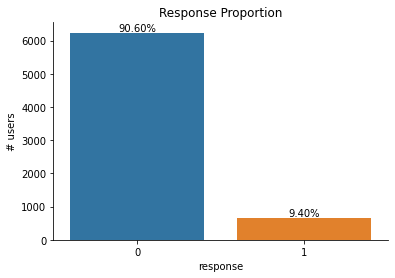

In [15]:
ax =sns.countplot(data=df, x='response')
for p in ax.patches:
  x = p.get_bbox().get_points()[:,0]
  y = p.get_bbox().get_points()[1,1]
  ax.annotate('{:.2f}%'.format(100*y/len(df)), (x.mean(), y), ha='center', va='bottom')
plt.title('Response Proportion')
plt.xlabel('response')
plt.ylabel('# users')
sns.despine()
plt.show()

In [23]:
target = "response"
ID = "customer_id"
features = [i for i in df.columns if i not in [target, ID]]
print(len(features), 'features')

5 features


In [16]:
## spliting dataframe into X and y

X = df.drop(columns=[ID,target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234, stratify = y)

print("Training Data", X_train.shape)
print("Testing Data", X_test.shape)

Training Data (4818, 5)
Testing Data (2066, 5)


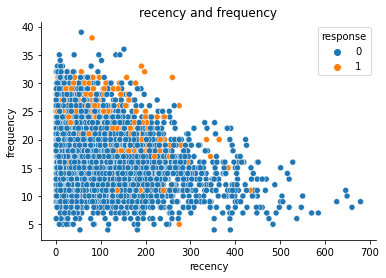

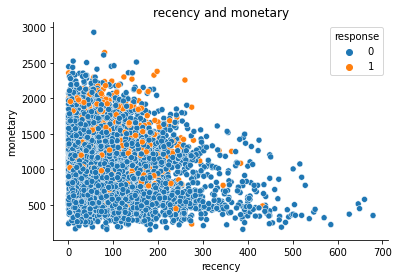

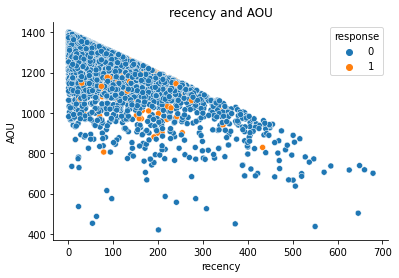

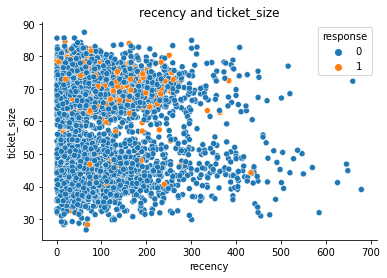

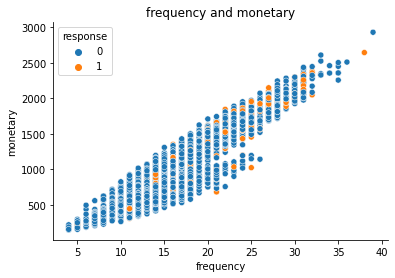

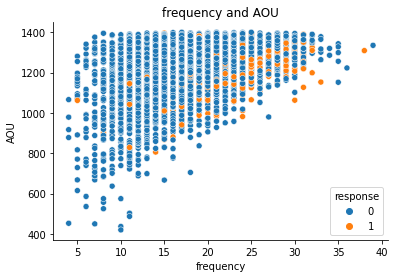

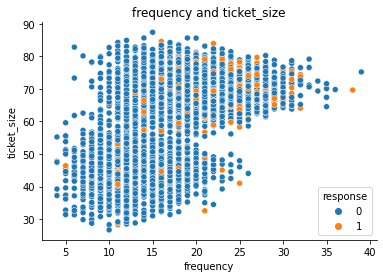

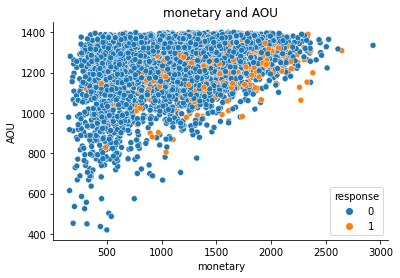

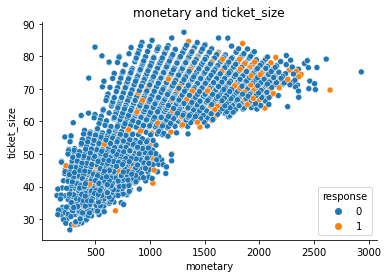

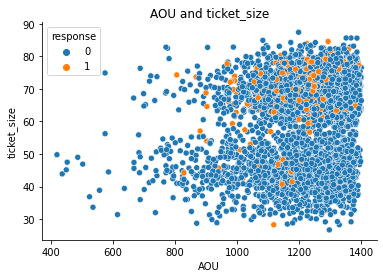

In [17]:
lst = ['recency', 'frequency', 'monetary', 'AOU', 'ticket_size']
for i, col_i in enumerate(lst):
  for j, col_j in enumerate(lst):
    if i < j :
      plt.title(col_i + ' and ' + col_j)
      sns.scatterplot(data=df, x=col_i, y=col_j, hue='response')
      sns.despine()
      plt.show()

### Box plot analysis

Number of features: 5


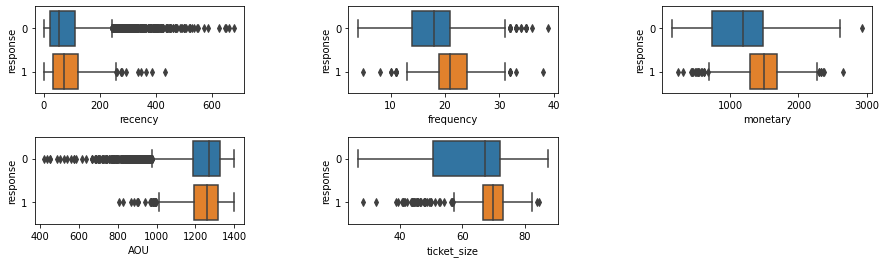

In [25]:
numfeat = len(features)
print("Number of features:", numfeat)
  
column = 3
row = int(np.ceil(numfeat/column))
fig = plt.figure()
fig.set_size_inches(column * 5, row * 2, forward=True)
fig.subplots_adjust(wspace=0.5, hspace=0.5)
fig.tight_layout()
for i, feat in enumerate(features):
  ax = fig.add_subplot(row,column,i+1)
  sns.boxplot(data=df, x=feat, y=target, ax=ax, orient='h')
plt.show()

### Pearson Correlation 

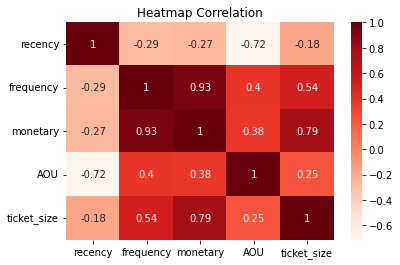

In [20]:
sns.heatmap(X.corr(), annot=True, cmap=plt.cm.Reds)
plt.title('Heatmap Correlation')
plt.show()

## Define Class weight for imbalance data

In [21]:
from collections import Counter
counter = Counter(y)
print(counter)

class_weight = counter[0]/counter[1]
print('Class weight :', class_weight)

Counter({0: 6237, 1: 647})
Class weight : 9.639876352395673


## Hyperparameter Tuning and Cross Validation using K-fold (k = 3)

In [27]:
params = {'min_child_weight':[4,6],
          'objective':['binary:logistic'],
          'learning_rate':[0.05,0.1],
          'gamma':[0.0],
          'subsample':[0.8,1.0],
          'colsample_bytree':[1.0],
          'max_depth':[4,6],
          'n_estimators':[100],
          'scale_pos_weight' : [class_weight],
          'seed':[1234]}
pg = ParameterGrid(params)
print("Parameter Grid contains {} parameter combinations".format(len(pg)))

Parameter Grid contains 16 parameter combinations


In [28]:
xgb = XGBClassifier()
grid_search = GridSearchCV(estimator = xgb, param_grid = params, scoring = 'roc_auc', cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 1234))
grid_search.fit(X_train, y_train)
print('\n Best Estimator')
print(grid_search.best_estimator_)
print('\n Best Score')
print(grid_search.best_score_)
print('\n Best Parameters')
print(grid_search.best_params_)
xgb_model = grid_search.best_estimator_


 Best Estimator
XGBClassifier(colsample_bytree=1.0, gamma=0.0, learning_rate=0.05, max_depth=4,
              min_child_weight=4, scale_pos_weight=9.639876352395673, seed=1234,
              subsample=1.0)

 Best Score
0.7199547878594782

 Best Parameters
{'colsample_bytree': 1.0, 'gamma': 0.0, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 100, 'objective': 'binary:logistic', 'scale_pos_weight': 9.639876352395673, 'seed': 1234, 'subsample': 1.0}


### Feature Importance

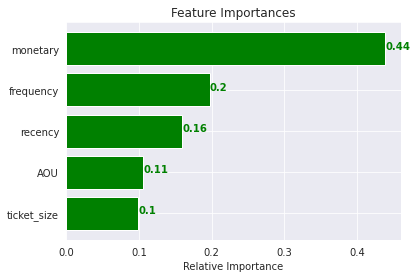

In [47]:
sns.set_style('darkgrid')
sns.set_palette('Set2')
importances = xgb_model.feature_importances_
indices = np.argsort(importances)
features = xgb_model.get_booster().feature_names
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='g', align = 'center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
for i, v in enumerate(indices):
  plt.text(importances[v], i, str(round(importances[v],2)), color='g', fontweight='bold')
plt.show()

### Evaluate ROC for Train Test dataset

Train: AUC = 0.8477, GINI = 0.6955
Test: AUC = 0.7146, GINI = 0.4291


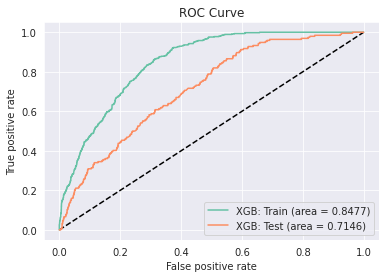

In [48]:
train_pred = xgb_model.predict_proba(X_train)[:,1]
test_pred = xgb_model.predict_proba(X_test)[:,1]

roc_train = roc_auc_score(y_train, train_pred)
roc_test = roc_auc_score(y_test, test_pred)

gini_train = (2*roc_train-1)
gini_test = (2*roc_test-1)
print('%s AUC = %0.4f, GINI = %0.4f' % ('Train:', roc_train, gini_train))
print('%s AUC = %0.4f, GINI = %0.4f' % ('Test:', roc_test, gini_test))

plt.figure(1)
plt.plot([0,1], [0,1], 'k--')

fpr, tpr, thresholds = roc_curve(y_train, train_pred)
auc_train = auc(fpr, tpr)
plt.plot(fpr, tpr, label = 'XGB: Train (area = {:,.4f})'.format(auc_train))

fpr, tpr, thresholds = roc_curve(y_test, test_pred)
auc_test = auc(fpr, tpr)
plt.plot(fpr, tpr, label = 'XGB: Test (area = {:,.4f})'.format(auc_test))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

In [37]:
print('Train Dataset')
print(classification_report(y_train,xgb_model.predict(X_train)))
print('Test Dataset')
print(classification_report(y_test,xgb_model.predict(X_test)))

Train Dataset
              precision    recall  f1-score   support

           0       0.99      0.62      0.76      4365
           1       0.20      0.92      0.33       453

    accuracy                           0.65      4818
   macro avg       0.59      0.77      0.55      4818
weighted avg       0.91      0.65      0.72      4818

Test Dataset
              precision    recall  f1-score   support

           0       0.95      0.61      0.74      1872
           1       0.15      0.67      0.25       194

    accuracy                           0.61      2066
   macro avg       0.55      0.64      0.49      2066
weighted avg       0.87      0.61      0.69      2066



### Check Correlation between feature and response & predicted prob

In [50]:
df_correlation = X_test.copy()
df_correlation[target] = y_test
df_correlation['PRED'] = test_pred

df_corr = df_correlation.corr(method = 'spearman')
df_corr = df_corr.loc[features, [target, 'PRED']]
df_corr = df_corr.reset_index().rename(columns = {'index':'Feature', target:'correlation_target', 'PRED':'correlation_pred'})
df_corr.sort_values(by = ['correlation_pred'], ascending=True, inplace = True)

print(df_corr.shape)
df_corr

(5, 3)


,Feature,correlation_target,correlation_pred
3,AOU,-0.034152,0.020753
0,recency,0.079198,0.131017
4,ticket_size,0.115100,0.555562
1,frequency,0.189851,0.799102
2,monetary,0.191675,0.833602


<Figure size 720x1080 with 0 Axes>

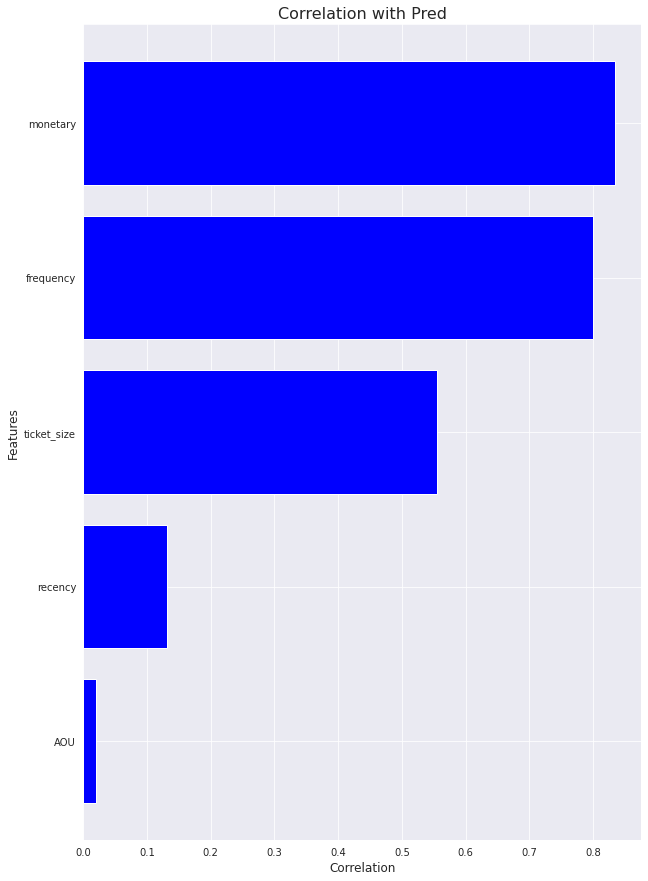

In [51]:
%matplotlib inline
 
plt_corr = plt.figure(figsize=(10,df_corr.shape[1]*5))
plt.figure(figsize=(10,df_corr.shape[1]*5))
x = df_corr['Feature']
x_pos = [i for i, _ in enumerate(x)]
x_pos = range(len(x))
plt.barh(x_pos, df_corr['correlation_pred'], color='blue')
plt.ylabel("Features", fontsize=12)
plt.tick_params(axis='y', labelsize=10)
plt.xlabel("Correlation", fontsize=12)
plt.title("Correlation with Pred", fontsize=16)
plt.yticks(x_pos, x)
plt.show()

## Partial Depence Plot (PDP)

Number of features: 5


/usr/local/lib/python3.7/dist-packages/sklearn/inspection/_partial_dependence.py:523: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/inspection/_partial_dependence.py:523: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/inspection/_partial_dependence.py:523: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  Futu

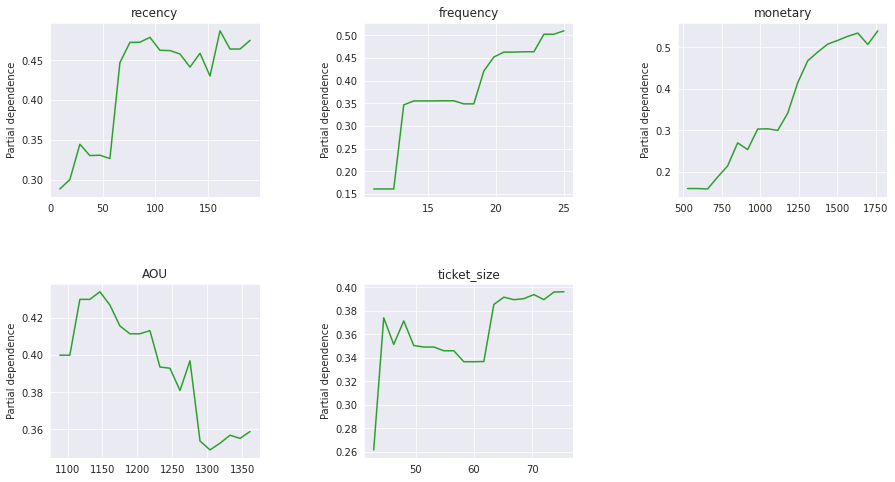

In [52]:
from sklearn.inspection import partial_dependence
 
numfeat = len(features)
print("Number of features:", numfeat)
  
column = 3
row = int(np.ceil(numfeat/column))
fig = plt.figure()
fig.set_size_inches(column * 5, row * 4, forward=True)
fig.subplots_adjust(wspace=0.5, hspace=0.5)
fig.tight_layout() 
 
for i, feat in enumerate(features): 
  pdp_table = partial_dependence(xgb_model, X_test, features=feat, percentiles=(0.1, 0.9), grid_resolution=20)
  ax = fig.add_subplot(row,column,i+1)
  ax.plot(pdp_table[1][0], pdp_table[0][0],  color='tab:green')
  ax.set_ylabel('Partial dependence')
  plt.title(feat)
 
plt.show()

### SHAP values of a model's output explain how features impact the output of the model

In [54]:
!pip install -q shap # Run this if you do not have shap installed
import shap

     |████████████████████████████████| 564 kB 7.7 MB/s 


In [57]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

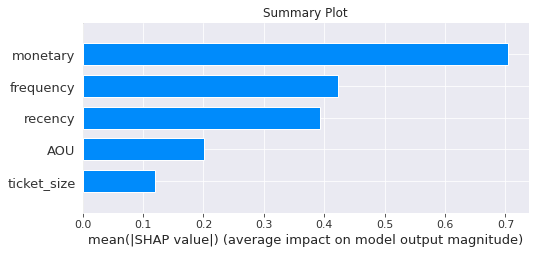

In [58]:
shap.summary_plot(shap_values, X_test.values, plot_type='bar', feature_names = features, show=False)
plt.title('Summary Plot')
plt.show()

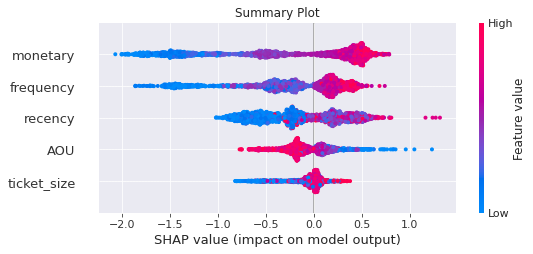

In [59]:
shap.summary_plot(shap_values, X_test.values, feature_names = features, show=False)
plt.title('Summary Plot')
plt.show()